In [1]:
!pip install findspark
!pip install pyspark
!pip install imbalanced_learn

  Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [2]:
import findspark
findspark.init()
findspark.find()

'/opt/conda/lib/python3.10/site-packages/pyspark'

# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Exploratory data analysis

In [4]:
spark = SparkSession.builder.getOrCreate()
data = spark.read.csv('data.csv', header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/25 00:09:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


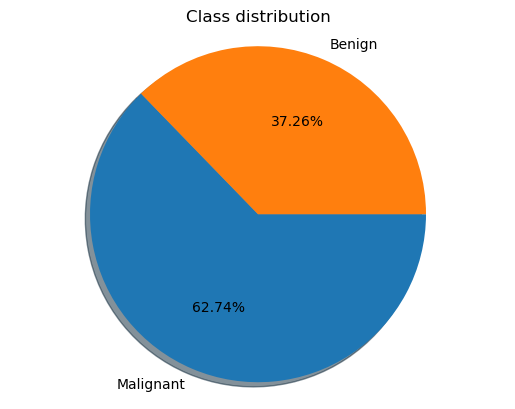

In [5]:
class_dis=data.groupBy("diagnosis").count().toPandas()
class_occur = class_dis['count']
class_names = ['Malignant', 'Benign']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

23/04/25 00:10:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


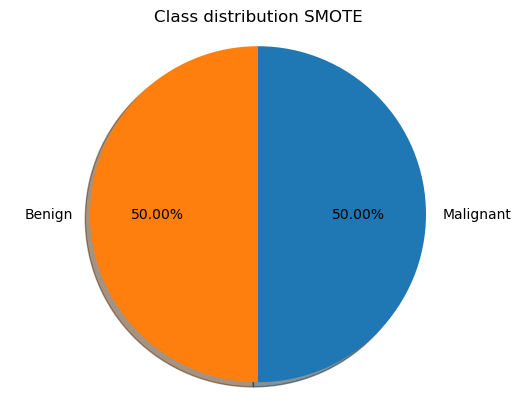

In [6]:
# Handle Imbalanced Classes
import numpy as np
from imblearn.over_sampling import SMOTE
# create the  object with the desired sampling strategy.
smote = SMOTE()
dfp = data.toPandas()
# fit the object to our training data
data2, y = smote.fit_resample(dfp.loc[:,dfp.columns!='diagnosis'], dfp['diagnosis'])

_, class_counts = np.unique(y, return_counts=True)
class_names = ['Malignant', 'Benign']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution SMOTE')
plt.show()
data2["diagnosis"] = y

In [7]:
data2.shape

(714, 32)

In [8]:
data2 = shuffle(data2)
data2

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
318,894329,9.042000,18.900000,60.070000,244.500000,0.099680,0.197200,0.197500,0.049080,0.233000,...,23.400000,68.620000,297.100000,0.122100,0.374800,0.460900,0.114500,0.313500,0.105500,B
399,904357,11.800000,17.260000,75.260000,431.900000,0.090870,0.062320,0.028530,0.016380,0.184700,...,24.490000,86.000000,562.000000,0.124400,0.172600,0.144900,0.053560,0.277900,0.081210,B
75,8610404,16.070000,19.650000,104.100000,817.700000,0.091680,0.084240,0.097690,0.066380,0.179800,...,24.560000,128.800000,1223.000000,0.150000,0.204500,0.282900,0.152000,0.265000,0.063870,M
315,894089,12.490000,16.850000,79.190000,481.600000,0.085110,0.038340,0.004473,0.006423,0.121500,...,19.710000,84.480000,544.200000,0.110400,0.049530,0.019380,0.027840,0.191700,0.061740,B
579,888438,17.678915,22.764885,116.782429,991.610938,0.091279,0.124918,0.104044,0.077422,0.207014,...,28.775057,141.042231,1365.700191,0.118397,0.287704,0.248988,0.154976,0.307782,0.075503,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,914101,12.460000,12.830000,78.830000,477.300000,0.073720,0.040430,0.007173,0.011490,0.161300,...,16.360000,83.240000,534.000000,0.094390,0.064770,0.016740,0.026800,0.228000,0.070280,B
67,859465,11.310000,19.040000,71.800000,394.100000,0.081390,0.047010,0.037090,0.022300,0.151600,...,23.840000,78.000000,466.700000,0.129000,0.091480,0.144400,0.069610,0.240000,0.066410,B
183,873843,11.410000,14.920000,73.530000,402.000000,0.090590,0.081550,0.061810,0.023610,0.116700,...,17.700000,79.120000,467.200000,0.112100,0.161000,0.164800,0.062960,0.181100,0.074270,B
504,915186,9.268000,12.870000,61.490000,248.700000,0.163400,0.223900,0.097300,0.052520,0.237800,...,16.380000,69.050000,300.200000,0.190200,0.344100,0.209900,0.102500,0.303800,0.125200,B


In [9]:
df = spark.createDataFrame(data2)

In [10]:
df.show(5)

+-------+-----------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------------+------------------+------------------+-----------------+----------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+---------+
|     id|      radius_mean|      texture_mean|    perimeter_mean|        area_mean|    smoothness_mean|   compactness_mean|     concavity_mean|concave_points_mean|      symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|     perimeter_se|         area_se|       smoothness_se|      compactness_se|       concavity_se|   concave_points_se|         symmetry_se|fra

# Creating the count framework

In [11]:
# Drop unncessary columns
df = df.drop("id")

# Create label encoder for diagnosis targets
Label_encoder=StringIndexer(inputCol="diagnosis",outputCol="diagnosis"+"Label").fit(df)

# Create feature assembler for input into spark
feature_cols = df.columns[0:-1]
featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Prepare the data
dataNew = featureAssembler.transform(Label_encoder.transform(df))

# Split the data into training and testing data
(trainingData, testData) = dataNew.randomSplit([0.7, 0.3])

In [12]:
cols = df.columns[0:-1]

In [13]:
np.array(cols).size

30

In [14]:
df.describe()

DataFrame[summary: string, radius_mean: string, texture_mean: string, perimeter_mean: string, area_mean: string, smoothness_mean: string, compactness_mean: string, concavity_mean: string, concave_points_mean: string, symmetry_mean: string, fractal_dimension_mean: string, radius_se: string, texture_se: string, perimeter_se: string, area_se: string, smoothness_se: string, compactness_se: string, concavity_se: string, concave_points_se: string, symmetry_se: string, fractal_dimension_se: string, radius_worst: string, texture_worst: string, perimeter_worst: string, area_worst: string, smoothness_worst: string, compactness_worst: string, concavity_worst: string, concave_points_worst: string, symmetry_worst: string, fractal_dimension_worst: string, diagnosis: string]

In [15]:
models = []

# Decision tree method

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier

# Define the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="diagnosisLabel", featuresCol="features", maxDepth=25)

# Hyperparameter tuning
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15, 20, 25]).build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="diagnosisLabel"),
                          parallelism=2,
                          numFolds=5)  # use 3+ folds in practice
# Train the DecisionTreeClassifier
decision_tree = crossval.fit(trainingData)
models.append(("Decision Tree", decision_tree))

23/04/13 13:57:25 WARN BlockManager: Block rdd_35_0 already exists on this machine; not re-adding it


# Random forest model

In [17]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="diagnosisLabel", featuresCol="features", numTrees=100, maxDepth=25)
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 15, 20, 25]) \
            .addGrid(rf.numTrees, [10, 25, 50, 75, 100, 150, 200]).build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="diagnosisLabel"),
                          parallelism=2,
                          numFolds=5)  # use 3+ folds in practice

random_forest = crossval.fit(trainingData)
models.append(("Random Forest", random_forest))

23/04/13 14:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
23/04/13 14:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
23/04/13 14:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
23/04/13 14:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
23/04/13 14:12:21 WARN BlockManager: Asked to remove block rdd_12087_13, which does not exist
23/04/13 14:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1009.6 KiB
23/04/13 14:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1009.6 KiB
23/04/13 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1009.6 KiB
23/04/13 14:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1009.6 KiB


# Multilayer perceptron classifier

In [18]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [30, 256, 128, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(labelCol="diagnosisLabel", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=1234)

paramGrid = ParamGridBuilder().addGrid(trainer.maxIter, [100, 200]).build()

crossval = CrossValidator(estimator=trainer,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="diagnosisLabel"),
                          parallelism=2,
                          numFolds=5)  # use 3+ folds in practice

# train the model
ML_perceptron = crossval.fit(trainingData)
models.append(("ML perceptron", ML_perceptron))

In [19]:
for item in models:
    model = item[1]
    # Make predictions
    predictions = model.transform(testData)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="diagnosisLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy", str(item[0]), "= " + str(accuracy))

Test set accuracy Decision Tree = 0.9585492227979274


23/04/13 14:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1059.1 KiB


Test set accuracy Random Forest = 0.9792746113989638


Test set accuracy ML perceptron = 0.9430051813471503
